### ¿Que hace un data scientist? 

Un **Data Scientist** analiza y modela datos para resolver problemas complejos y apoyar la toma de decisiones basadas en evidencia. Sus principales tareas incluyen:  

1. **Recolección de datos**: Extrae información de diversas fuentes, como bases de datos, APIs, o archivos.  
2. **Limpieza y preprocesamiento**: Elimina errores, inconsistencias o valores faltantes para garantizar la calidad de los datos.  
3. **Exploración de datos**: Identifica patrones, tendencias y relaciones utilizando análisis descriptivo y visualizaciones.  
4. **Modelado predictivo y estadístico**: Aplica técnicas como Machine Learning, regresión, clustering o redes neuronales para predecir resultados o clasificar datos.  
5. **Interpretación de resultados**: Traduce análisis técnicos en insights comprensibles para los tomadores de decisiones.  
6. **Automatización y optimización**: Desarrolla soluciones para automatizar procesos y mejorar sistemas existentes.  

Actúa en sectores como finanzas, marketing, salud, logística y más, ayudando a las organizaciones a ser más eficientes, competitivas y basadas en datos.


Un Data Scientist necesita conocer **SARIMAX** y especializarse en **series temporales** porque muchas decisiones empresariales dependen de **predecir eventos futuros** basados en datos históricos, como ventas, demanda, precios, o riesgos financieros. SARIMAX permite modelar y predecir estas tendencias considerando factores estacionales (**S**), dependencias de datos pasados (**AR** y **MA**) y variables externas (**X**), siendo clave en campos como:

- **Finanzas**: Predicción de precios de activos o volatilidad.  
- **Marketing**: Estimación de demanda de productos.  
- **Operaciones**: Optimización de inventarios y recursos.  

Esta especialización lo hace indispensable en análisis predictivo y en la creación de estrategias basadas en datos.

# PRONOSTICO DE SERIES TEMPORALES

## MODELO SARIMAX 

- Libro: Time Series Forecasting (Marco Peixeiro - Edit. Manning)

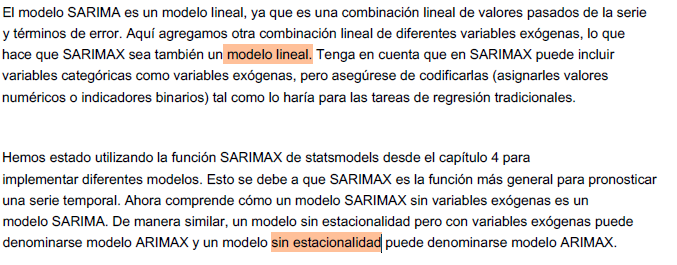

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


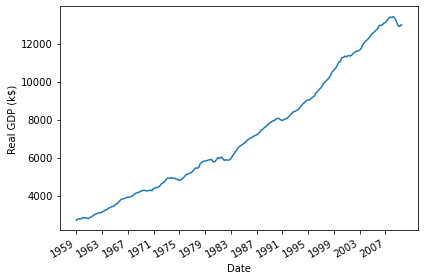

In [3]:
fig, ax = plt.subplots()

ax.plot(macro_econ_data['realgdp'])
ax.set_xlabel('Date')
ax.set_ylabel('Real GDP (k$)')

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH09_F01_peixeiro.png', dpi=300)

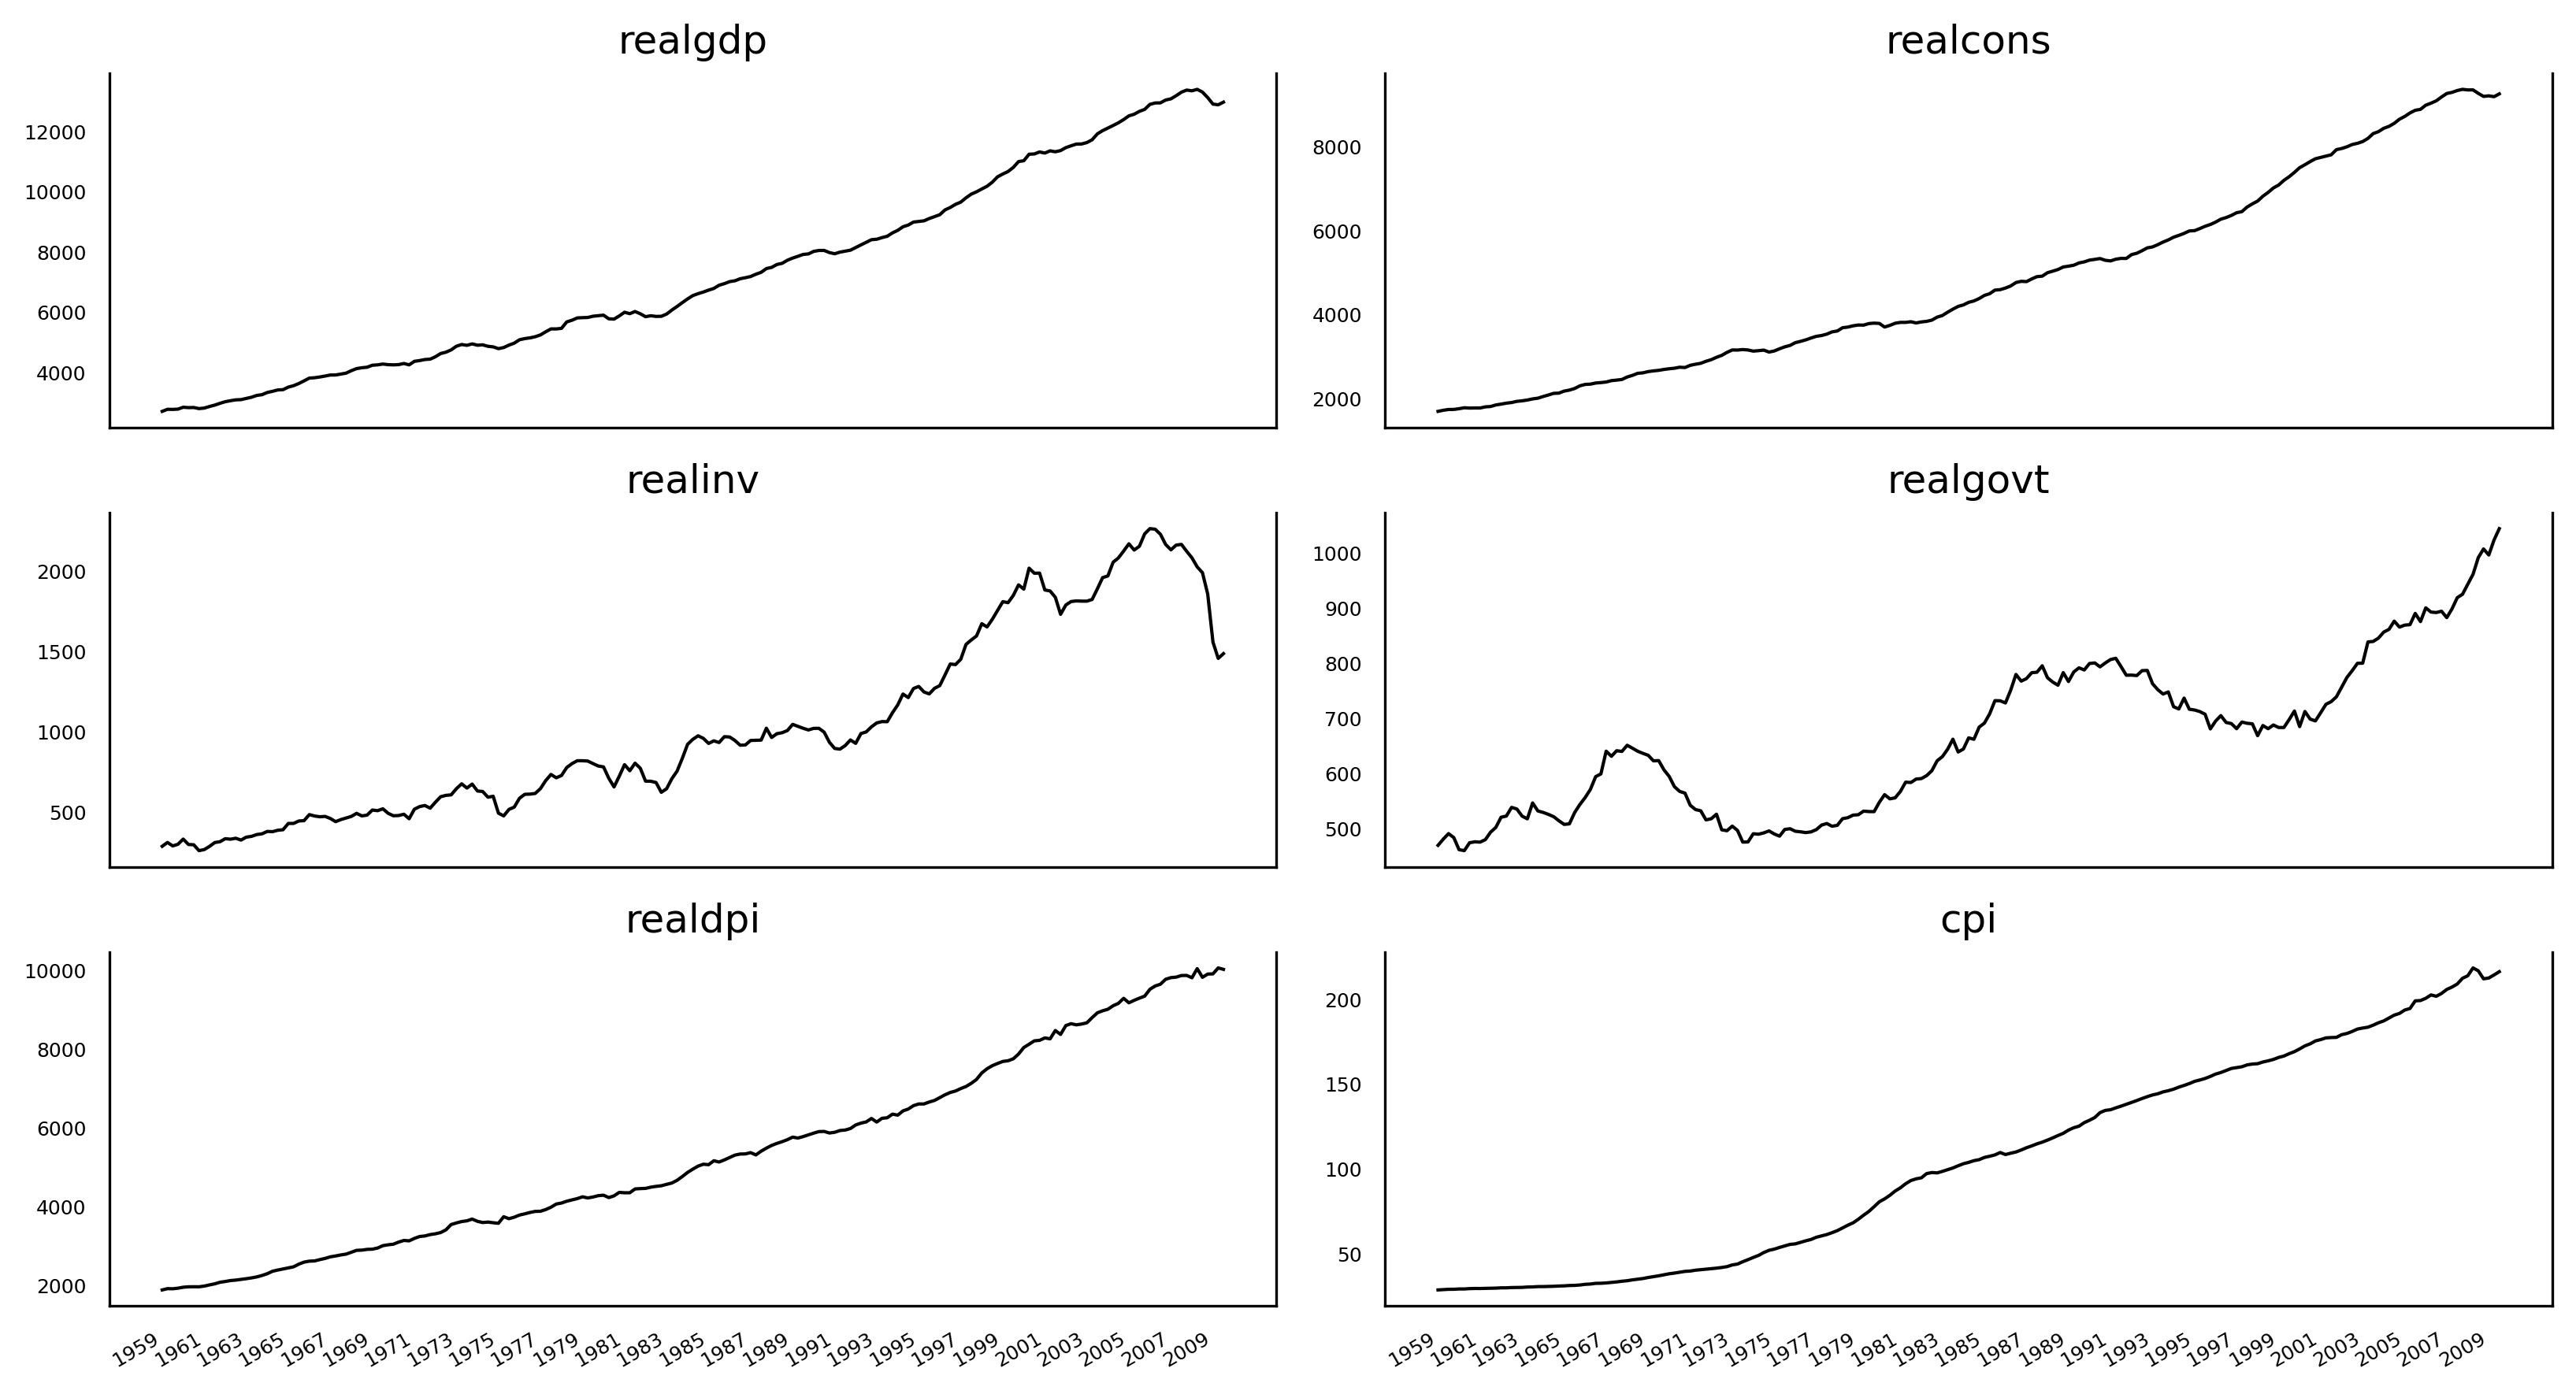

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=300, figsize=(11,6))

for i, ax in enumerate(axes.flatten()[:6]):
    data = macro_econ_data[macro_econ_data.columns[i+2]]
    
    ax.plot(data, color='black', linewidth=1)
    ax.set_title(macro_econ_data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.setp(axes, xticks=np.arange(0, 208, 8), xticklabels=np.arange(1959, 2010, 2))
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('figures/CH09_F02_peixeiro.png', dpi=300)

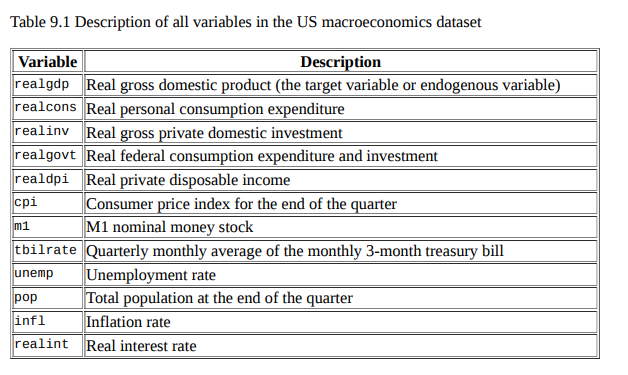

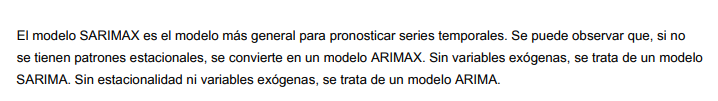

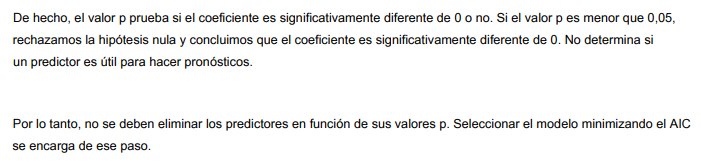

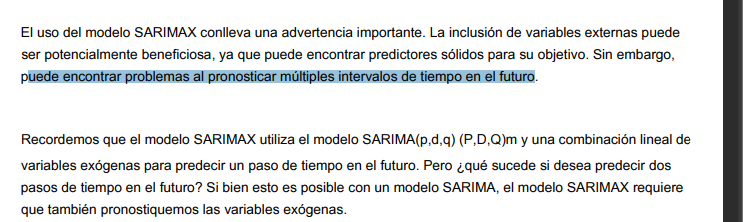

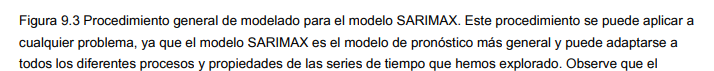

In [5]:
target = macro_econ_data['realgdp']
exog = macro_econ_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi']]

In [6]:
ad_fuller_result = adfuller(target)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 1.7504627967647166
p-value: 0.9982455372335032


In [7]:
target_diff = target.diff()

ad_fuller_result = adfuller(target_diff[1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.305695561658104
p-value: 3.327882187668259e-08


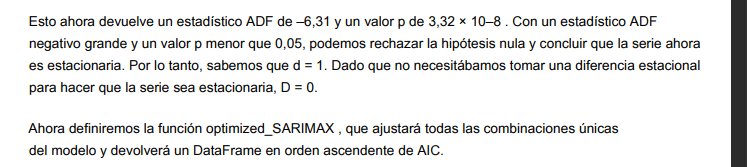

### parámetros del modelo **SARIMA(p,d,q)(P,D,Q)m** que se utiliza dentro de **SARIMAX**:

1. **p**: Orden del componente autorregresivo (AR).  
   - Indica cuántos valores pasados de la serie se utilizarán para predecir el futuro.

2. **d**: Diferenciación no estacional.  
   - Número de veces que se diferencia la serie para que sea estacionaria.

3. **q**: Orden del componente de media móvil (MA).  
   - Representa cuántos errores pasados se incluyen en el modelo.

4. **P**: Orden autorregresivo estacional (AR estacional).  
   - Similar a "p" pero en términos del componente estacional.

5. **D**: Diferenciación estacional.  
   - Número de diferencias estacionales necesarias para la estacionariedad.

6. **Q**: Orden de media móvil estacional (MA estacional).  
   - Similar a "q" pero aplicado a los errores de la parte estacional.

7. **m**: Frecuencia o período de la estacionalidad.  
   - Representa la cantidad de observaciones por ciclo estacional (por ejemplo, 12 para datos mensuales con estacionalidad anual).

En resumen, los parámetros **p, d, q** son para la parte no estacional, mientras que **P, D, Q, m** capturan la parte estacional del modelo. SARIMA extiende a ARIMA para manejar datos con estacionalidad. Mientras que en el modelo SARIMAX extiende a SARIMA incorporando variables exogenas

In [8]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame: # especificamos tipos de datos desde la funcion
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

La función **`optimize_SARIMAX`** tiene como objetivo **encontrar los mejores parámetros** de un modelo **SARIMAX** que minimicen el valor de **AIC** (Criterio de Información de Akaike):

---

### **¿Qué hace la función?**

1. **Propósito**:  
   Prueba diferentes combinaciones de parámetros para el modelo SARIMAX y selecciona los que minimizan el **AIC**, que es una métrica para evaluar la calidad del modelo penalizando su complejidad.

2. **Entradas (Parámetros)**:
   - **`endog`**: Variable endógena (serie temporal objetivo) → Puede ser una `pd.Series` o una `list`.  
   - **`exog`**: Variable exógena (predictor adicional o regresor) → Opcional, también puede ser `pd.Series` o `list`.  
   - **`order_list`**: Lista de combinaciones de órdenes \((p, q, P, Q)\) a evaluar.  
   - **`d`**: Número de diferenciaciones no estacionales.  
   - **`D`**: Número de diferenciaciones estacionales.  
   - **`s`**: Período de estacionalidad (frecuencia del ciclo).

3. **Salidas**:
   - Un **DataFrame** con las combinaciones de parámetros \((p, q, P, Q)\) y sus respectivos valores de **AIC**, ordenados de menor a mayor AIC.

---

### **¿Cómo funciona paso a paso?**

1. **Inicializa una lista vacía para almacenar los resultados**:
   ```python
   results = []
   ```

2. **Itera sobre todas las combinaciones de parámetros (`order_list`)**:
   ```python
   for order in tqdm_notebook(order_list):
   ```
   - `tqdm_notebook` muestra una barra de progreso para seguir el proceso (útil en notebooks).  
   - Cada combinación `order` contiene valores para \((p, q, P, Q)\).

3. **Ajusta el modelo SARIMAX** para cada combinación:
   ```python
   model = SARIMAX(
       endog,
       exog,
       order=(order[0], d, order[1]),
       seasonal_order=(order[2], D, order[3], s),
       simple_differencing=False).fit(disp=False)
   ```
   - **`order`**: Parámetros no estacionales \((p, d, q)\).  
   - **`seasonal_order`**: Parámetros estacionales \((P, D, Q, s)\).  
   - **`simple_differencing`**: Evita la diferenciación automática adicional.  
   - **`fit(disp=False)`**: Ajusta el modelo SARIMAX sin mostrar detalles del ajuste.

4. **Maneja errores**:
   ```python
   except:
       continue
   ```
   - Si el ajuste del modelo falla con una combinación, el bucle **continúa** sin interrumpir el proceso.

5. **Guarda el valor de AIC y la combinación de parámetros**:
   ```python
   aic = model.aic
   results.append([order, aic])
   ```

6. **Crea un DataFrame con los resultados**:
   ```python
   result_df = pd.DataFrame(results)
   result_df.columns = ['(p,q,P,Q)', 'AIC']
   ```
   - Se asignan nombres a las columnas: combinación de parámetros y su respectivo AIC.

7. **Ordena el DataFrame por AIC (menor es mejor)**:
   ```python
   result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
   ```

8. **Devuelve el DataFrame ordenado**:
   ```python
   return result_df
   ```

---

### **Resumen del flujo de la función**:

1. Prueba varias combinaciones de parámetros SARIMAX.
2. Ajusta un modelo SARIMAX por cada combinación.
3. Guarda el valor de **AIC** para cada modelo.
4. Devuelve un **DataFrame ordenado** con las mejores combinaciones (las que tienen menor AIC).

---

### **Ejemplo de uso en tu notebook**:
```python
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm.notebook import tqdm_notebook
import pandas as pd
from typing import Union

# Definir parámetros y combinaciones
order_list = [(1, 1, 1, 1), (2, 1, 1, 1), (1, 2, 2, 2)]  # Ejemplo de combinaciones
d, D, s = 1, 1, 12  # Parámetros específicos
endog = pd.Series(...)  # Tu serie temporal
exog = pd.Series(...)  # Variables exógenas opcionales

# Optimizar SARIMAX
resultados = optimize_SARIMAX(endog, exog, order_list, d, D, s)
print(resultados)
```

---

### **Beneficio**:
Esta función **automatiza** la búsqueda de los mejores parámetros para SARIMAX, **optimizando tiempo** y seleccionando la mejor combinación de parámetros de forma eficiente.

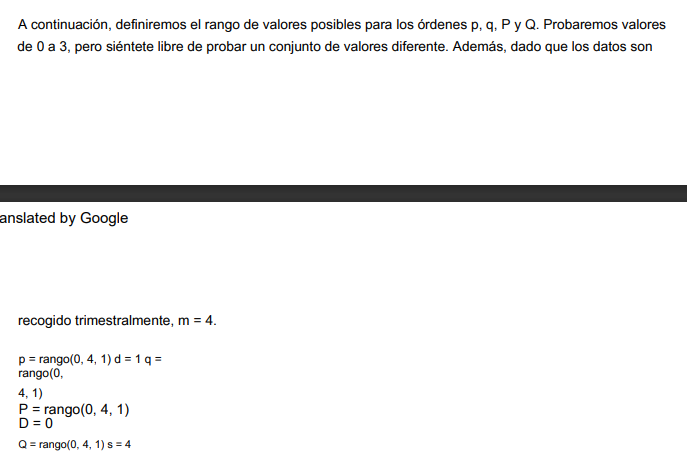

In [9]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

### QUE ES " AIC " ? 
La **AIC** (Criterio de Información de Akaike, por sus siglas en inglés **Akaike Information Criterion**) es una métrica utilizada para **seleccionar el mejor modelo** en problemas de series temporales, como en SARIMA o SARIMAX.

### **¿Qué mide la AIC?**
La AIC evalúa **cuán bien un modelo se ajusta a los datos**, pero penaliza la complejidad del modelo para evitar el sobreajuste (**overfitting**). Es decir:
- Favorece modelos que se ajustan bien a los datos.  
- Prefiere modelos más simples cuando tienen un desempeño similar.  

La fórmula de AIC es:
\[
AIC = 2k - 2\ln(L)
\]
donde:  
- \( k \): Número de parámetros del modelo (complejidad).  
- \( L \): Máxima verosimilitud (likelihood) del modelo.  

### **¿Cómo interpretar la AIC?**
- **Un valor más bajo de AIC indica un mejor modelo**.  
- Se comparan los valores de AIC entre diferentes modelos; el que tenga el valor más bajo se considera el mejor.  

---

### **Ejemplo práctico**  
Si estás comparando modelos SARIMA con diferentes combinaciones de parámetros \((p, d, q) \text{ y } (P, D, Q)\), seleccionas el modelo con **la AIC más baja**.  

Esto facilita la **selección del modelo óptimo** sin necesidad de pruebas manuales excesivas.

In [10]:
target_train = target[:200]
exog_train = exog[:200]

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 3, 0, 0)",1742.862713
1,"(3, 3, 1, 0)",1744.966704
2,"(3, 3, 0, 1)",1744.998032
3,"(2, 2, 0, 0)",1745.422233
4,"(2, 2, 0, 1)",1745.902126
...,...,...
251,"(0, 2, 0, 0)",1761.579044
252,"(0, 3, 0, 0)",1762.317095
253,"(0, 0, 0, 0)",1764.754980
254,"(1, 0, 0, 0)",1765.379412


In [11]:
best_model = SARIMAX(target_train, exog_train, order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  200
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -859.431
Date:                Tue, 10 Aug 2021   AIC                           1742.863
Time:                        19:03:39   BIC                           1782.382
Sample:                             0   HQIC                          1758.857
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9652      0.044     21.693      0.000       0.878       1.052
realinv        1.0142      0.033     30.944      0.000       0.950       1.078
realgovt       0.7249      0.127      5.717      0.0

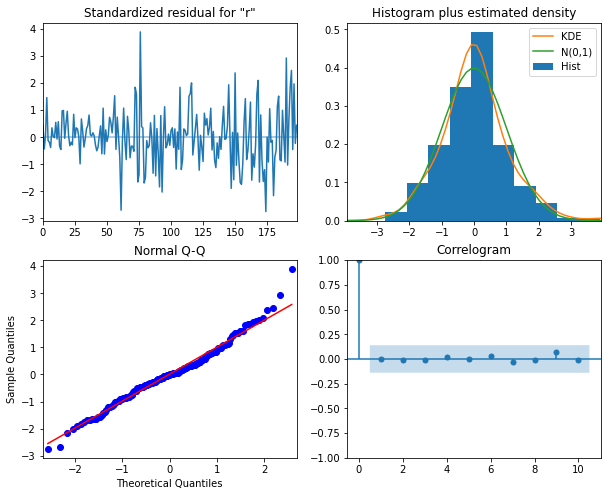

In [12]:
best_model_fit.plot_diagnostics(figsize=(10,8));

plt.savefig('figures/CH09_F05_peixeiro.png', dpi=300)

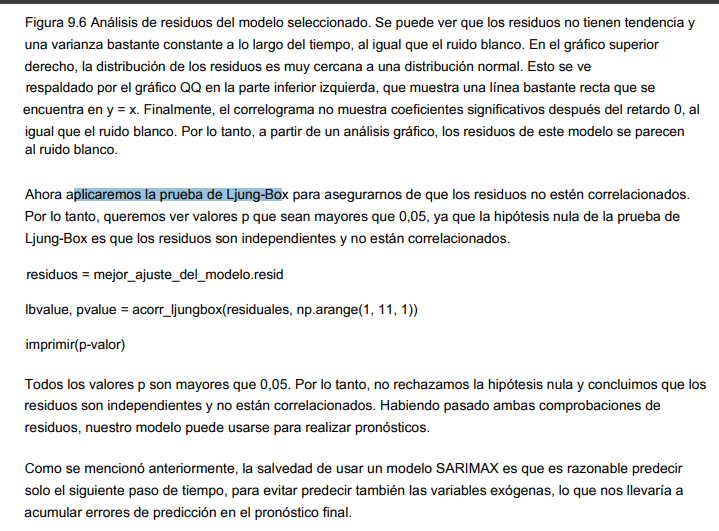

In [13]:
residuals = best_model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

[0.77623545 0.90319605 0.97607253 0.88600353 0.94919895 0.97823588
 0.98639909 0.99447738 0.99494287 0.99794752]


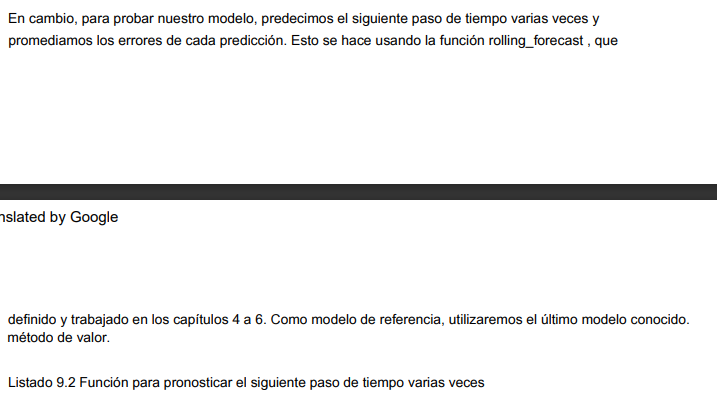

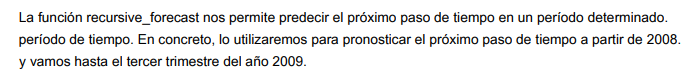

In [14]:
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [15]:
target_train = target[:196]
target_test = target[196:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df

,actual,pred_last_value,pred_SARIMAX
196,13366.865,13391.249,13344.064608
197,13415.266,13366.865,13373.511905
198,13324.600,13415.266,13378.794970
199,13141.920,13324.600,13327.976995
200,12925.410,13141.920,13133.870439
201,12901.504,12925.410,12886.936039
202,12990.341,12901.504,12873.792890


In [16]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

print(mape_last, mape_SARIMAX)

0.736849498653785 0.7038858060965504


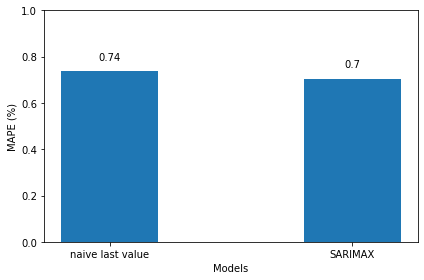

In [19]:
fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

plt.savefig('figures/CH09_F06_peixeiro.png', dpi=300)

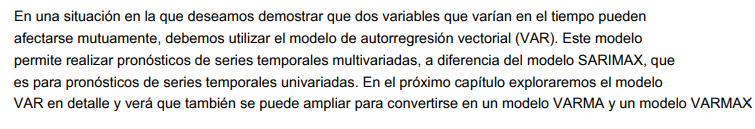